<a href="https://colab.research.google.com/github/tomfirer/NLP_Assignment2/blob/main/NLP_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#imports
import pandas as pd
import numpy as np

from scipy import sparse

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.extmath import randomized_svd

from gensim.models import Word2Vec

import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from nltk.grammar import CFG
from nltk.parse.chart import ChartParser

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
### functions ###
def tokenize_nltk(sentence_arr: list[str]) -> list[list[str]]:
  result_tokens_array = []

  for sentence in sentence_arr:
    result_tokens_array.append(nltk.word_tokenize(sentence))

  return result_tokens_array


def stem_nltk(token_mat: list[list[str]]) -> list[list[str]]:
  stemming_result = []
  ls = LancasterStemmer()

  for token_arr in token_mat:
    stemming_result.append([ls.stem(token) for token in token_arr])

  return stemming_result


def remove_stopwords(token_mat: list[list[str]]) -> list[list[str]]:
  stopwords_list = stopwords.words('english')
  filtered_tokens = [[token for token in token_arr if token not in stopwords_list and token.isalpha()] for token_arr in token_mat]
  #filtered_tokens = [[token for token in token_arr if token.isalpha()] for token_arr in token_mat]
  return filtered_tokens


def bow_feature_extraction(corpus: list[str]):
  vectorizer = CountVectorizer()
  bow_mat = vectorizer.fit_transform(corpus)
  return (vectorizer, bow_mat)


def tfidf_feature_extraction(corpus: list[str]):
  vectorizer = TfidfVectorizer()
  tfidf_mat = vectorizer.fit_transform(corpus)
  return (vectorizer, tfidf_mat)


#"untokenizes" a matrix of tokens back into an array of strings
def token_matrix_to_string_array(token_mat: list[list[str]]) -> list[str]:
  return [' '.join([str(x) for x in token_arr]) for token_arr in token_mat]


def build_cooccurrence_matrix(corpus, window_size=2):
    vocab = list(set(corpus))
    word_to_id = {word: i for i, word in enumerate(vocab)}
    cooccurrence = sparse.lil_matrix((len(vocab), len(vocab)), dtype=np.float64)

    for i, word in enumerate(corpus):
        left_context = max(0, i - window_size)
        right_context = min(len(corpus), i + window_size + 1)
        for j in range(left_context, right_context):
            if i != j:
                cooccurrence[word_to_id[word], word_to_id[corpus[j]]] += 1

    return cooccurrence.tocsr(), word_to_id


def glove_loss(X, W, b, U, c):
    return np.sum(np.power(W.dot(U.T) + b[:, np.newaxis] + c[np.newaxis, :] - np.log(X.toarray() + 1), 2))


def train_glove(X, vector_size=50, iterations=100, learning_rate=0.01):
    vocab_size = X.shape[0]
    W = np.random.randn(vocab_size, vector_size) / np.sqrt(vector_size)
    U = np.random.randn(vocab_size, vector_size) / np.sqrt(vector_size)
    b = np.zeros(vocab_size)
    c = np.zeros(vocab_size)

    for _ in range(iterations):
        grad_W = 2 * (W.dot(U.T) + b[:, np.newaxis] + c[np.newaxis, :] - np.log(X.toarray() + 1)).dot(U)
        grad_U = 2 * (W.dot(U.T) + b[:, np.newaxis] + c[np.newaxis, :] - np.log(X.toarray() + 1)).T.dot(W)
        grad_b = 2 * np.sum(W.dot(U.T) + b[:, np.newaxis] + c[np.newaxis, :] - np.log(X.toarray() + 1), axis=1)
        grad_c = 2 * np.sum(W.dot(U.T) + b[:, np.newaxis] + c[np.newaxis, :] - np.log(X.toarray() + 1), axis=0)

        W -= learning_rate * grad_W
        U -= learning_rate * grad_U
        b -= learning_rate * grad_b
        c -= learning_rate * grad_c

        '''
        if _ % 10 == 0:
            print(f"Iteration {_}, Loss: {glove_loss(X, W, b, U, c)}")
        '''
    return (W + U) / 2

In [42]:
### Loading data from txt file ###
with open('whatsapp_messages.txt', 'r') as file:
    messages = file.readlines()

whatsapp_df = pd.DataFrame(messages, columns=['Messages'])
whatsapp_df

,Messages
0,"Hey team, quick reminder: today's meeting is a..."
1,Does anyone have the latest sales report? Need...
2,Happy Friday everyone! Any plans for the weeke...
3,"Just a heads up, the printer on the 3rd floor ..."
4,Can someone review the draft proposal I just s...
...,...
72,IT update: network upgrade scheduled for this ...
73,Congrats to the accounting team for closing th...
74,Reminder: company-wide town hall meeting next ...
75,HR update: wellness program launches next week...


In [43]:
tokens = tokenize_nltk(whatsapp_df['Messages'])
print(tokens)

[['Hey', 'team', ',', 'quick', 'reminder', ':', 'today', "'s", 'meeting', 'is', 'at', '10', 'AM', 'in', 'Conference', 'Room', 'A', '.'], ['Does', 'anyone', 'have', 'the', 'latest', 'sales', 'report', '?', 'Need', 'it', 'for', 'the', 'presentation', '.'], ['Happy', 'Friday', 'everyone', '!', 'Any', 'plans', 'for', 'the', 'weekend', '?'], ['Just', 'a', 'heads', 'up', ',', 'the', 'printer', 'on', 'the', '3rd', 'floor', 'is', 'out', 'of', 'toner', 'again', '.'], ['Can', 'someone', 'review', 'the', 'draft', 'proposal', 'I', 'just', 'sent', 'over', '?'], ['Reminder', ':', 'team', 'lunch', 'at', 'noon', ',', 'we', "'re", 'going', 'to', 'that', 'new', 'place', 'downtown', '!'], ['Has', 'anyone', 'seen', 'my', 'blue', 'notebook', '?', 'I', 'think', 'I', 'left', 'it', 'in', 'the', 'meeting', 'room', '.'], ['Important', ':', 'The', 'deadline', 'for', 'project', 'submissions', 'has', 'been', 'extended', 'to', 'Friday', '.'], ['Who', "'s", 'attending', 'the', 'client', 'meeting', 'tomorrow', '?', '

In [44]:
stem = stem_nltk(tokens)
print(stem)

[['hey', 'team', ',', 'quick', 'remind', ':', 'today', "'s", 'meet', 'is', 'at', '10', 'am', 'in', 'conf', 'room', 'a', '.'], ['doe', 'anyon', 'hav', 'the', 'latest', 'sal', 'report', '?', 'nee', 'it', 'for', 'the', 'pres', '.'], ['happy', 'friday', 'everyon', '!', 'any', 'plan', 'for', 'the', 'weekend', '?'], ['just', 'a', 'head', 'up', ',', 'the', 'print', 'on', 'the', '3rd', 'flo', 'is', 'out', 'of', 'ton', 'again', '.'], ['can', 'someon', 'review', 'the', 'draft', 'propos', 'i', 'just', 'sent', 'ov', '?'], ['remind', ':', 'team', 'lunch', 'at', 'noon', ',', 'we', "'re", 'going', 'to', 'that', 'new', 'plac', 'downtown', '!'], ['has', 'anyon', 'seen', 'my', 'blu', 'notebook', '?', 'i', 'think', 'i', 'left', 'it', 'in', 'the', 'meet', 'room', '.'], ['import', ':', 'the', 'deadlin', 'for', 'project', 'submit', 'has', 'been', 'extend', 'to', 'friday', '.'], ['who', "'s", 'attend', 'the', 'cli', 'meet', 'tomorrow', '?', 'nee', 'to', 'fin', 'the', 'agend', '.'], ['good', 'morn', '!', 'cou

In [45]:
filtered = remove_stopwords(stem)
print(filtered)

[['hey', 'team', 'quick', 'remind', 'today', 'meet', 'conf', 'room'], ['doe', 'anyon', 'hav', 'latest', 'sal', 'report', 'nee', 'pres'], ['happy', 'friday', 'everyon', 'plan', 'weekend'], ['head', 'print', 'flo', 'ton'], ['someon', 'review', 'draft', 'propos', 'sent', 'ov'], ['remind', 'team', 'lunch', 'noon', 'going', 'new', 'plac', 'downtown'], ['anyon', 'seen', 'blu', 'notebook', 'think', 'left', 'meet', 'room'], ['import', 'deadlin', 'project', 'submit', 'extend', 'friday'], ['attend', 'cli', 'meet', 'tomorrow', 'nee', 'fin', 'agend'], ['good', 'morn', 'could', 'someon', 'ad', 'calend', 'invit', 'next', 'week', 'workshop'], ['emerg', 'maint', 'build', 'today', 'expect', 'som', 'disrupt'], ['remind', 'submit', 'yo', 'expens', 'report', 'end', 'day'], ['flo', 'seem', 'look'], ['someon', 'bring', 'extr', 'laptop', 'charg', 'meet', 'room'], ['congr', 'market', 'team', 'success', 'campaign', 'launch'], ['forget', 'upd', 'yo', 'project', 'stat', 'shar', 'driv'], ['happy', 'birthday', 'sa

In [46]:
corpus = token_matrix_to_string_array(filtered)
print(corpus)

['hey team quick remind today meet conf room', 'doe anyon hav latest sal report nee pres', 'happy friday everyon plan weekend', 'head print flo ton', 'someon review draft propos sent ov', 'remind team lunch noon going new plac downtown', 'anyon seen blu notebook think left meet room', 'import deadlin project submit extend friday', 'attend cli meet tomorrow nee fin agend', 'good morn could someon ad calend invit next week workshop', 'emerg maint build today expect som disrupt', 'remind submit yo expens report end day', 'flo seem look', 'someon bring extr laptop charg meet room', 'congr market team success campaign launch', 'forget upd yo project stat shar driv', 'happy birthday sarah hr cak break room pm', 'remind mand train sess cybersec tomorrow afternoon', 'nee volunt char ev next mon', 'got cal cli lov propos', 'weath upd snow expect tomorrow morn plan yo commut accord', 'anyon avail cov afternoon famy emerg', 'forget rsvp ret next mon', 'kudo team fix serv issu quick', 'next week p

In [47]:
### bow ###
bow_vectorizer, bow_mat = bow_feature_extraction(corpus)
#print(bow_mat.toarray())
print(bow_vectorizer.get_feature_names_out())

['access' 'accord' 'account' 'achiev' 'act' 'ad' 'adv' 'afternoon' 'agend'
 'ahead' 'al' 'analyst' 'annount' 'anyon' 'apolog' 'apply' 'approv'
 'attend' 'audit' 'avail' 'await' 'badg' 'bak' 'bin' 'birthday' 'blu'
 'bonus' 'book' 'brainstorm' 'break' 'brief' 'bring' 'budget' 'build'
 'cafeter' 'cak' 'cal' 'calend' 'campaign' 'cas' 'caus' 'ceo' 'chang'
 'char' 'charg' 'check' 'cle' 'cleanup' 'cli' 'clos' 'cod' 'coff'
 'comfort' 'commit' 'commut' 'company' 'complet' 'conduc' 'conf' 'confus'
 'congr' 'congrat' 'contact' 'correct' 'could' 'cov' 'cybersec' 'dat'
 'day' 'deadlin' 'dec' 'depart' 'deploy' 'detail' 'direct' 'dish'
 'disrupt' 'distribut' 'doe' 'downtim' 'downtown' 'draft' 'dress' 'dril'
 'driv' 'due' 'ear' 'east' 'effect' 'elev' 'els' 'emerg' 'employ' 'end'
 'ens' 'eod' 'ev' 'everyon' 'everyth' 'expect' 'expens' 'expery' 'extend'
 'extr' 'facil' 'famy' 'feedback' 'fin' 'fir' 'fix' 'flex' 'flo' 'flu'
 'food' 'forecast' 'forget' 'fre' 'friday' 'fridg' 'furnit' 'going' 'good'
 'got'

In [48]:
### tf-idf ###
(tfidf_vectorizer, tfidf_mat) = tfidf_feature_extraction(corpus)
#print(tfidf_mat.toarray())

print('idf values:')
for x, y in zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_):
    print(x, ':', y)

idf values:
access : 4.663561646129646
accord : 4.258096538021482
account : 4.663561646129646
achiev : 4.663561646129646
act : 4.663561646129646
ad : 4.663561646129646
adv : 4.663561646129646
afternoon : 3.970414465569701
agend : 4.258096538021482
ahead : 4.258096538021482
al : 4.663561646129646
analyst : 4.663561646129646
annount : 4.663561646129646
anyon : 3.5649493574615367
apolog : 4.663561646129646
apply : 4.663561646129646
approv : 4.663561646129646
attend : 4.663561646129646
audit : 4.258096538021482
avail : 3.970414465569701
await : 4.663561646129646
badg : 4.663561646129646
bak : 4.663561646129646
bin : 4.663561646129646
birthday : 4.663561646129646
blu : 4.663561646129646
bonus : 4.663561646129646
book : 4.663561646129646
brainstorm : 4.663561646129646
break : 3.970414465569701
brief : 4.663561646129646
bring : 3.970414465569701
budget : 4.663561646129646
build : 4.258096538021482
cafeter : 4.663561646129646
cak : 4.663561646129646
cal : 4.663561646129646
calend : 4.663561646

In [49]:
### word2vec ###
model = Word2Vec(
    sentences=filtered,      # The corpus to train the model on
    vector_size=100,       # The size of the word vectors to be learned
    window=5,              # The size of the window of words to be considered
    min_count=5,           # The minimum frequency required for a word to be included in the vocabulary
    sg=0,                  # 0 for CBOW, 1 for skip-gram
    negative=5,            # The number of negative samples to use for negative sampling
    ns_exponent=0.75,      # The exponent used to shape the negative sampling distribution
    alpha=0.03,            # The initial learning rate
    min_alpha=0.0007,      # The minimum learning rate to which the learning rate will be linearly reduced
    epochs=30,             # The number of epochs (iterations) over the corpus
    workers=4,             # The number of worker threads to use for training the model
    seed=42,               # The seed for the random number generator
    max_vocab_size=None    # The maximum vocabulary size (None means no limit)
)

In [70]:
# Get the vector representation of a word
vector = model.wv['meet']
print(vector)

# Find the most similar words to a given word
similar_words = model.wv.most_similar('meet')
print(similar_words)

[ 0.00046955  0.00246088 -0.00657358 -0.00662472 -0.00740587  0.00151375
 -0.00996802  0.00129441 -0.00057318 -0.0006462   0.00336445  0.00076377
  0.00485038  0.00543765  0.00856834  0.00621316  0.0003397  -0.00071978
 -0.00554283  0.00201861 -0.00750517  0.00872081  0.00699603 -0.00745183
  0.00626097 -0.00807785  0.00426581 -0.00819646 -0.00044776  0.00320382
  0.00446766 -0.00167724  0.00839336  0.005448   -0.00572245  0.00329694
  0.00487798 -0.00393586  0.00452472  0.00820178  0.00669729  0.00518764
  0.00281951 -0.00481871  0.005896   -0.00274699  0.00041199 -0.00338897
 -0.00328239 -0.00708277  0.0094967  -0.00727885 -0.00829264  0.00879492
  0.00107632 -0.00120312  0.00465814 -0.002194   -0.00725007  0.00479378
 -0.00602969  0.00115684  0.00863228  0.00918325 -0.00258672  0.00582413
  0.00236454 -0.00029315 -0.00724836 -0.00257986  0.00303882  0.00955376
 -0.0098784   0.00436666  0.00715004  0.00911226 -0.00137055 -0.00790597
 -0.00453254  0.00711724  0.00789315  0.00271543 -0

In [74]:
### GloVe ###
flattened_token_mat = [item for sublist in filtered_token_mat for item in sublist]
X, word_to_id = build_cooccurrence_matrix(flattened_token_mat)

word_vectors = train_glove(X, vector_size=5, iterations=100)

# Print word vectors
for word, idx in word_to_id.items():
    print(f"{word}: {word_vectors[idx]}")

head: [-0.42031434  0.14491817  0.03749161  0.06656245 -0.15839617]
report: [ 0.07542117  0.20516485  0.33094874  0.33428721 -0.18768884]
hey: [ 0.16733381 -0.34718205  0.25480317  0.04981404 -0.14295262]
flo: [-0.44597597  0.17013033  0.10119604 -0.13220771 -0.12125267]
anyon: [ 0.36368201  0.36526248 -0.00053467 -0.00662262 -0.26955379]
sent: [-0.09003012 -0.04666228  0.11781857 -0.32050347  0.19144759]
ton: [-0.44019123  0.09276387  0.07469052 -0.17979776  0.01242731]
conf: [ 0.04842689 -0.03338508 -0.52377857 -0.08643112 -0.25216779]
propos: [ 0.0109131  -0.08235386  0.21734242 -0.34181348  0.36730235]
draft: [-0.02173753 -0.07059831  0.1355808  -0.33558539  0.43840243]
weekend: [-0.30154447  0.04157671  0.02570522  0.27322934 -0.01321236]
ov: [-0.09079286 -0.09487804 -0.13754965 -0.21496478  0.16427709]
hav: [ 0.20874151  0.32510341 -0.02036246  0.04908563 -0.3152141 ]
team: [ 0.20503121 -0.39270596  0.31477872  0.05438171 -0.23104315]
review: [-0.31407201 -0.02329878  0.17339847 

GloVe (Global Vectors for Word Representation) is a method used to create vector representations of words without needing labeled data. It analyzes how often words appear together in a text to find relationships between them. This approach allows GloVe to capture the meaning of words and their connections. For example, it can understand that "king" minus "man" plus "woman" is similar to "queen."

In [92]:
### cyk ###
# Define the grammar in Chomsky Normal Form (CNF)
grammar = CFG.fromstring("""
    S -> NP VP | VP
    NP -> N | Det N | NP NP | NP PP | Pro | Adj NP
    VP -> V | V NP | V PP | Adv VP | VP Adv
    PP -> Prep NP
    Det -> 'the' | 'a'
    Adj -> 'quick' | 'latest' | 'happy' | 'any' | 'just'
    Adv -> 'just' | 'up' | 'out' | 'again' | 'ov'
    N -> 'hey' | 'team' | 'remind' | 'today' | 'meet' | 'am' | 'conf' | 'room' | 'a' | 'doe' | 'sal' | 'report' | 'nee' | 'pres' | 'friday' | 'plan' | 'weekend' | 'head' | 'print' | 'flo' | 'out' | 'ton' | 'can' | 'review' | 'draft' | 'propos' | 'rsvp' | 'ret' | 'mon'
    V -> 'team' | 'remind' | 'meet' | 'is' | 'am' | 'doe' | 'hav' | 'sal' | 'report' | 'nee' | 'plan' | 'head' | 'print' | 'can' | 'review' | 'draft' | 'sent' | 'forget' | 'ret'
    Prep -> 'through' | 'bef' | 'at' | 'in' | 'for' | 'on' | 'of' | 'next'
    Pro -> 'i' | 'anyon' | 'it' | 'everyon' | 'any' | 'someon'
""")

In [93]:
for sentence in token_matrix_to_string_array(filtered[0:5]):
  print(sentence)

hey team quick remind today meet conf room
doe anyon hav latest sal report nee pres
happy friday everyon plan weekend
head print flo ton
someon review draft propos sent ov


In [94]:
# Initialize the parser
parser = ChartParser(grammar)

# Set data to parse
filtered_token_mat = filtered[0:5]

res_parses = []

# Parse each sentence in the
for token_arr in filtered_token_mat:
  parses = list(parser.parse(token_arr))
  res_parses.append(parses)

In [95]:
# Scroll through results
sentene_dictionary = {'sentence 1':0, 'sentence 2':1, 'sentence 3':2, 'sentence 4':3, 'sentence 5':4}

sentence = 'sentence 4' #@param ['sentence 1', 'sentence 2', 'sentence 3', 'sentence 4', 'sentence 5']
i = sentene_dictionary[sentence]

print(token_matrix_to_string_array([filtered[i]]))

# Check if the sentence is in the language and print the parse trees
if res_parses[i]:
  print("Sentence is in the language.")
  print(f"Found {len(res_parses[i])} different parse trees.")
  for tree in res_parses[i]:
    tree.pretty_print()
else:
  print("Sentence is not in the language.")

['head print flo ton']
Sentence is in the language.
Found 3 different parse trees.
            S         
            |          
            VP        
  __________|___       
 |              NP    
 |           ___|___   
 |          NP      | 
 |      ____|___    |  
 |     NP       NP  NP
 |     |        |   |  
 V     N        N   N 
 |     |        |   |  
head print     flo ton

            S             
            |              
            VP            
  __________|___           
 |              NP        
 |      ________|___       
 |     |            NP    
 |     |         ___|___   
 |     NP       NP      NP
 |     |        |       |  
 V     N        N       N 
 |     |        |       |  
head print     flo     ton

            S             
  __________|___           
 |              VP        
 |      ________|___       
 |     |            NP    
 |     |         ___|___   
 NP    |        NP      NP
 |     |        |       |  
 N     V        N       N 
 |    

In [101]:
print(token_matrix_to_string_array([filtered[22]]))


parse_res = list(parser.parse(filtered[22]))

if parse_res:
  print("Sentence is in the language.")
  print(f"Found {len(parse_res)} different parse trees.")
  for tree in parse_res:
    tree.pretty_print()
else:
  print("Sentence is not in the language.")


['forget rsvp ret next mon']
Sentence is in the language.
Found 2 different parse trees.
                 S                  
                 |                   
                 VP                 
   ______________|___                
  |                  NP             
  |           _______|________       
  |          NP               PP    
  |      ____|___         ____|___   
  |     NP       NP      |        NP
  |     |        |       |        |  
  V     N        N      Prep      N 
  |     |        |       |        |  
forget rsvp     ret     next     mon

             S                  
             |                   
             VP                 
   __________|___                
  |              NP             
  |      ________|___            
  |     |            NP         
  |     |     _______|____       
  |     |    |            PP    
  |     |    |        ____|___   
  |     NP   NP      |        NP
  |     |    |       |        |  
  V     N    N      P

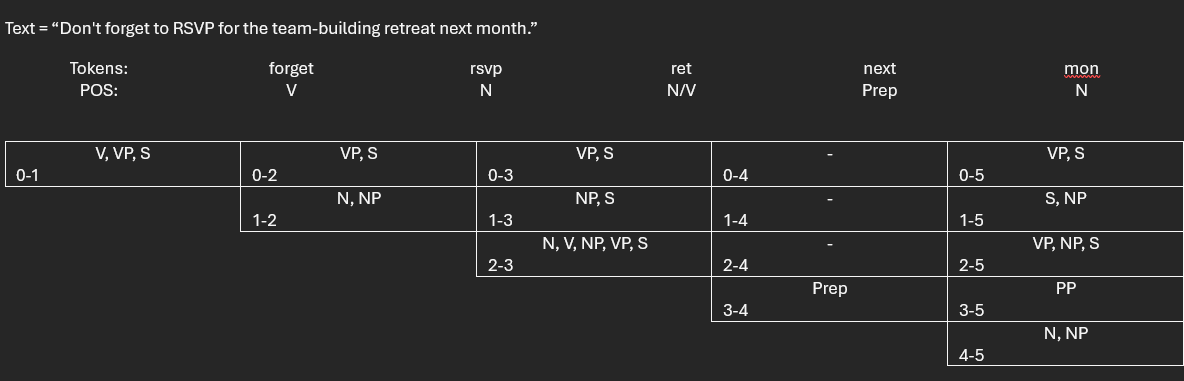